# Training run 2019-08-07

## Premise

- Q: what happens if we run training for much longer than we ever have done so far, with a simple linear epsilon decay?

## Conclusion

Basically the same thing happens again. Notably, the learned policy is fairly conservative up to 125, betting about half its bankroll each time (still more aggressive than Kelly Criterion, of course) - but above $125, perhaps in an attempt to finish the game in one bet, it seems to want to bet exactly whatever is left to get to the end goal of 250.

In [1]:
# Notebook setup

import os
REPO_ROOT = "D:\\play\\kelly-criterion"
os.chdir(REPO_ROOT)
print(f"Working directory: {os.getcwd()}")

Working directory: D:\play\kelly-criterion


In [2]:
# Imports and function definitions

import matplotlib.pyplot as plt
import numpy as np

from src.environment import Environment
from src.agent import Agent

def run_training(train_from_fresh, num_episodes, epsilons, exploring_start=False):
    env = Environment()

    if train_from_fresh:
        agent = Agent(env)

        total_rewards = agent.train(env, num_episodes=num_episodes, epsilons_each_episode=epsilons,
                                    exploring_start=exploring_start, plot_training_rewards=True,
                                   use_tensorboard=True)

        agent.plot_N_values()

    else:
        agent = Agent(Q_values=np.loadtxt("Q.csv"))

    agent.plot_Q_values()

    agent.plot_policy(
        optimal_policy=[min(250 - s, 0.2 * s) for s in range(1, 250)]
    )


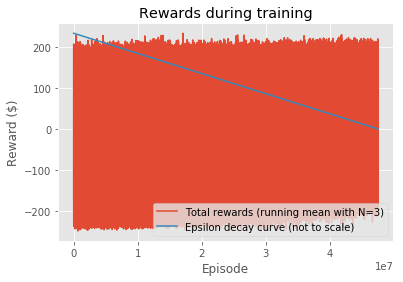

D:\play\kelly-criterion\src\agent.py:137: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(self._N))


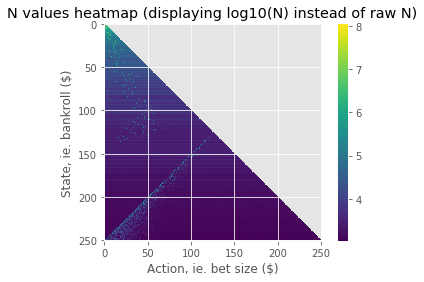

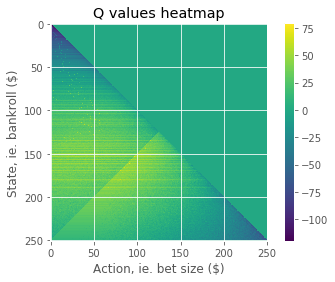

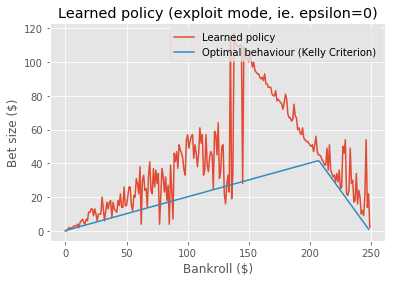

In [3]:
# Run the training

DESIRED_TRAIN_NUM_SECONDS = 12 * 60 * 60  # 12 hours
APPROX_EPISODES_PER_SECOND = 1100

train_num_episodes = APPROX_EPISODES_PER_SECOND * DESIRED_TRAIN_NUM_SECONDS

run_training(train_from_fresh=True,
           num_episodes=train_num_episodes,
             epsilons=np.linspace(1, 0, train_num_episodes),
           exploring_start=True)



# Agent evaluation 2019-08-08

## Premise

- Q: What if this RL agent knows something we don't, and its learnt policy is actually better?

## Conclusion

- It's not. Over 100,000 episodes in exploit mode, **our trained agent got a mean total reward of 87.91**, but the 'optimal' agent that follows Kelly Criterion got a mean reward of **211.93**.

In [7]:
from pathlib import Path

env = Environment()

trained_agent = Agent(env, load_from_directory=Path('models/latest'), load_N=True)
trained_agent.save_parameters(Path('models/2019-08-07'))


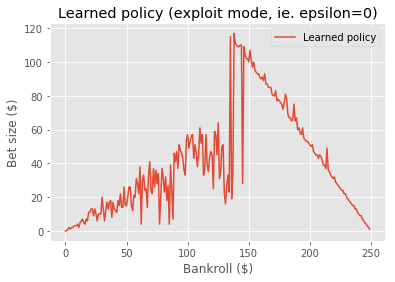

In [9]:
trained_agent.plot_policy()

In [10]:
episodes_num = 100000

def evaluate(agent):
    env = Environment()
    total_reward = 0
    for ep in range(episodes_num):
        episode_reward = 0
        state = env.reset()
        while True:
            bet_size = agent.act(state, explore_probability=0)
            new_state, reward, finished, dbg_info = env.step(bet_size)
            state = new_state
            episode_reward += reward
            if finished:
                break
        total_reward += episode_reward
    return total_reward

evaluate(trained_agent)

8791060.0

In [15]:
class KellyAgent:
    
    _kelly_bet_sizes = [min(250 - s, 0.2 * s) for s in range(0, 251)]    
    
    def act(self, state, explore_probability=0):
        if explore_probability > 0:
            raise NotImplementedError
        return self._kelly_bet_sizes[int(state)]

kelly_agent = KellyAgent()
evaluate(kelly_agent)

21193161.400000624